## Import dataset




In [2]:
import pandas as pd

df = pd.read_csv('ads_all.csv')
print(df.head())


   id                              ad_id  \
0   1  2b245180a2df401d91d205226a6f5889/   
1   2  c688c6c29231491796a683f7a4126006/   
2   3  20e7537262574ffaa63989e950542f32/   
3   4  d4d0bd4fb6cb40a6b2f8edfd577dbc7f/   
4   5  0e70caa1d9f446a79ea846ecc8add920/   

                                                link  num_of_pic    price  \
0  https://uae.dubizzle.com/motors/used-cars/ford...        17.0  159,000   
1  https://uae.dubizzle.com/motors/used-cars/ford...        18.0  276,000   
2  https://uae.dubizzle.com/motors/used-cars/ford...        19.0   62,500   
3  https://uae.dubizzle.com/motors/used-cars/ford...        19.0  169,000   
4  https://uae.dubizzle.com/motors/used-cars/ford...        19.0  209,000   

  brand            model                                              title  \
0  Ford  F-Series Pickup  SVT Raptor 2018 F150 under service contract Fe...   
1  Ford          Mustang  Ford Mustang Shelby, original, American import...   
2  Ford             Edge  Black Pac

## Data exploration




(21122, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21122 entries, 0 to 21121
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21122 non-null  int64  
 1   ad_id          21122 non-null  object 
 2   link           21122 non-null  object 
 3   num_of_pic     20872 non-null  float64
 4   price          20876 non-null  object 
 5   brand          20876 non-null  object 
 6   model          20876 non-null  object 
 7   title          20871 non-null  object 
 8   year           20872 non-null  float64
 9   km             20872 non-null  object 
 10  steering_side  20872 non-null  object 
 11  region_specs   20872 non-null  object 
 12  location       20872 non-null  object 
 13  tags           4522 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 2.3+ MB
None
                 id    num_of_pic          year
count  21122.000000  20872.000000  20872.000000
mean   1056

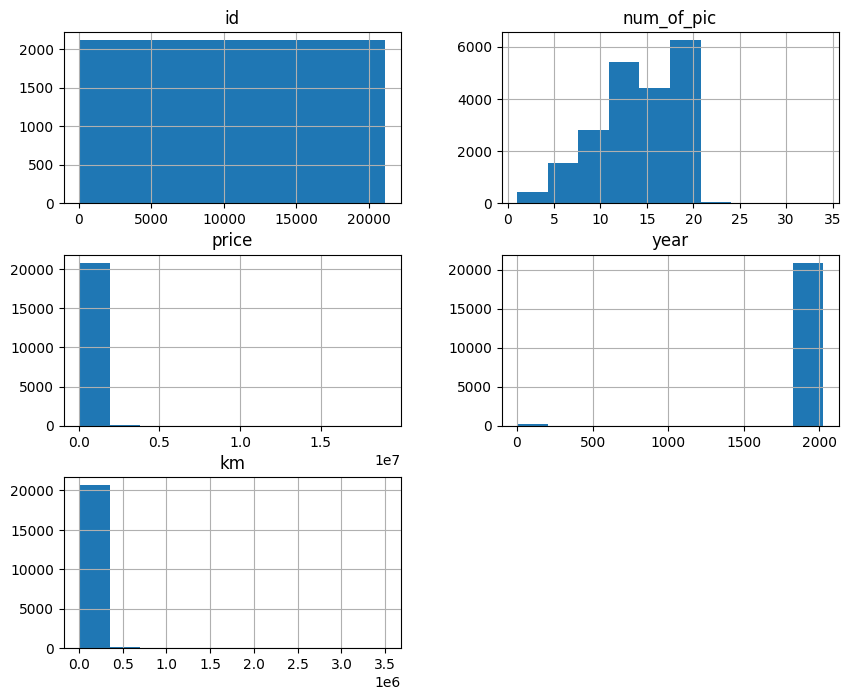

In [3]:
# Examine the DataFrame
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize the distribution of numerical features
import matplotlib.pyplot as plt
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace(',', '') # Remove commas before converting to float
df['price'] = df['price'].astype(float)
df['year'] = df['year'].fillna(0).astype(int) # Fill missing years with 0
df['km'] = df['km'].str.replace(',', '').str.replace(' km', '').astype(float)
df.hist(figsize=(10, 8))
plt.show()


---

## Data cleaning



In [4]:
df = df.drop(['num_of_pic', 'region_specs', 'tags'], axis=1)


In [5]:
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the columns with missing values
imputer.fit(df[['brand', 'model', 'title', 'steering_side', 'location']])

# Transform the columns with missing values
df[['brand', 'model', 'title', 'steering_side', 'location']] = imputer.transform(df[['brand', 'model', 'title', 'steering_side', 'location']])



In [6]:
from scipy.stats.mstats import winsorize

# Winsorize the 'price' and 'km' columns
df['price'] = winsorize(df['price'], limits=[0.05, 0.05])
df['km'] = winsorize(df['km'], limits=[0.05, 0.05])



In [7]:
df = df.drop('title', axis=1)



In [12]:
# Save cleaned dataset
df.to_csv('ads_cleaned.csv', index=False)

## Feature engineering




In [8]:
# Create interaction term between 'year' and 'km'
df['year_km_interaction'] = df['year'] * df['km']

# Create polynomial features for 'year' and 'km'
df['year_squared'] = df['year'] ** 2
df['km_squared'] = df['km'] ** 2



## Data preparation




In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify categorical and numerical features
categorical_features = ['brand', 'model', 'steering_side', 'location']
numerical_features = ['year', 'km', 'year_km_interaction', 'year_squared', 'km_squared']

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_categorical = encoder.fit_transform(df[categorical_features])

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_features])

# Combine transformed features
import pandas as pd
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))
scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_features)
processed_df = pd.concat([df[['price']], scaled_df, encoded_df], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Train test split




In [10]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = processed_df.drop('price', axis=1)
y = processed_df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Model training




In [15]:
# Import the RandomForestRegressor class.
from sklearn.ensemble import RandomForestRegressor

# Instantiate a RandomForestRegressor object.
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data.
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Model optimization




In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for Gradient Boosting and Random Forest models
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Create grid search object
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)

# Fit grid search object to training data
grid_search_rf.fit(X_train, y_train)

# Print best hyperparameters
best_rf_model = grid_search_rf.best_estimator_
print(best_rf_model)

# Save trained model as pkl
import pickle
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

## Model evaluation



In [14]:
from sklearn.metrics import mean_absolute_error

# Predict car prices on the testing data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
rf_predictions = best_rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, rf_predictions)

# Print the MAE value
print(mae_rf)
mae = mean_absolute_error(y_test, y_pred)


17853.212367121116
